In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio # We only need the Audio 'Class' from this package

# Class 8 - DST Lab Spring 2024
## New York University

***

## STFT and Spectrogram

# Generating a "melodic" test signal

Generate a three second long test signal with the following three sine waves. Use a sample rate of 48kHz and an amplitude of 1 for all sines

- A4: starts at t=0s and lasts two seconds
- C\#5: starts at t=1s and lasts one second
- G\#4: starts at t=2s and lasts one second

In [2]:
def sine_gen(amplitude, frequency, phase, duration, sample_rate):
    t_v = np.arange(0, duration, 1/sample_rate) 
    output = amplitude * np.sin(2 * np.pi * frequency * t_v + phase)
    return output

(0.0, 1000.0)

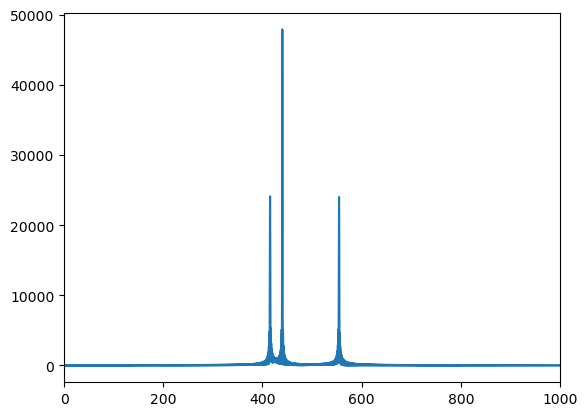

In [6]:
sr = 48000

sine1 = sine_gen(1, 440, 0, 2, sr) # A4
sine2 = sine_gen(1, 554.37, 0, 1, sr) # C#5
sine3 = sine_gen(1, 415.3, 0, 1, sr) # G#4

melody = np.zeros(3*sr)

melody[0:sr*2] = melody[0:sr*2] + sine1
melody[sr:sr*2] = melody[sr:sr*2] + sine2
melody[sr*2:] = melody[sr*2:] + sine3

display(Audio(melody, rate = sr))

melody_fft = np.fft.rfft(melody)

melody_mag = np.abs(melody_fft)

melody_freq = np.fft.rfftfreq(len(melody), 1/sr)

plt.plot(melody_freq, melody_mag)
plt.xlim([0, 1000]) 

## Intro to spectrogram - Buffers of Time

In order to analyze the development of the frequency content of a signal over time, the audio vector will have to be broken into smaller "chunks" of data.

 - Create a function that generates a matrix that contains a signal broken into buffers.
 - Each column of the matrix will represent a different moment in time
 - The length of each column (number of rows) will be defined by the user

In [3]:
#grab each block of audio
   # define size of column
   # find start/end indices of blocks
   # copy data in between start/end points to matrix

## Non-overlapping STFT

Create a function that breaks an audio signal into non-overlapping chunks (or buffers) of audio (using a rectangular window) and displays the fourier transform of ONE given buffer (Freq vs Amplitude) while applying one of the following windows:

Inputs:

- in [mono audio vector]
- buffer_size [frame/buffer size]
- display_frame [frame/buffer to display]

In [7]:
# break the following array up into blocks of size 4
# store each block using a 2 dimensional array
# for example: out[0][2] will return the sample at index 2 of block number 0

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

x[0:4]

#first block
    # start index is 0
    # end index is 3
    
#second block
    #start index is 4
    #end index is 7
    
frame_sz = 4

num_frames = int(np.ceil(len(x) / frame_sz))

print(num_frames)

3


In [8]:
def fft_buf(x, frame_sz, disp_num):
    num_frames = int(np.ceil(len(x) / frame_sz))
    mat = np.zeros([num_frames, frame_sz])
    
    # curr_frame = x[0:frame_sz]
    # second_frame = x[frame_sz:frame_sz*2]
    # third_frame = x[frame_sz*2:frame_sz*3]
    
    for i in range(0, num_frames):
        start = i * frame_sz
        end = start + frame_sz
        # end = (i + 1) * frame_sz
        curr_frame  = x[start:end]
        #first number is inclusive
        #second is exclusive
        
        mat[i, 0:len(curr_frame)] += curr_frame
    
    mat_fft = np.fft.rfft(mat[disp_num])
    
    mag_fft = abs(mat_fft)
    
    f_v = np.fft.rfftfreq(len(mat[disp_num]), 1/48000)
    
    plt.stem(f_v, mag_fft)
    
    return mag_fft

(0.0, 800.0)

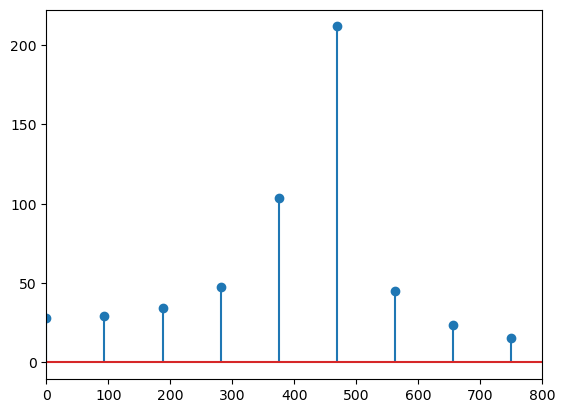

In [10]:
buffer_s = 512

x_fft = fft_buf(melody, buffer_s, 10)
plt.xlim([0, 800])

In [11]:
sr/buffer_s

93.75

## Zero Padding

    -pad each buffer with zeros so we can perform an FFT with a larger N value on the same signal

In [12]:
x = np.array([1, 2, 3, 4, 5])

x_z = np.pad(x, [0, 5])

print(x_z)

[1 2 3 4 5 0 0 0 0 0]


In [13]:
def fft_buf_zpad(x, frame_sz, disp_num, fft_len):
    num_frames = int(np.ceil(len(x) / frame_sz))
    mat = np.zeros([num_frames, frame_sz])
    
    # curr_frame = x[0:frame_sz]
    # second_frame = x[frame_sz:frame_sz*2]
    # third_frame = x[frame_sz*2:frame_sz*3]
    
    for i in range(0, num_frames):
        start = i * frame_sz
        end = start + frame_sz
        # end = (i + 1) * frame_sz
        curr_frame  = x[start:end]
        #first number is inclusive
        #second is exclusive
        
        mat[i, 0:len(curr_frame)] += curr_frame
    
    mat_fft = np.fft.rfft(mat[disp_num], fft_len)
    
    mag_fft = abs(mat_fft)
    
    # f_v = np.fft.rfftfreq(fft_len, 1/48000)
    f_v = np.arange(0, sr, sr/fft_len)
    
    plt.stem(f_v[0:len(mag_fft)], mag_fft)
    plt.xlim([0, 800])
    
    return mag_fft

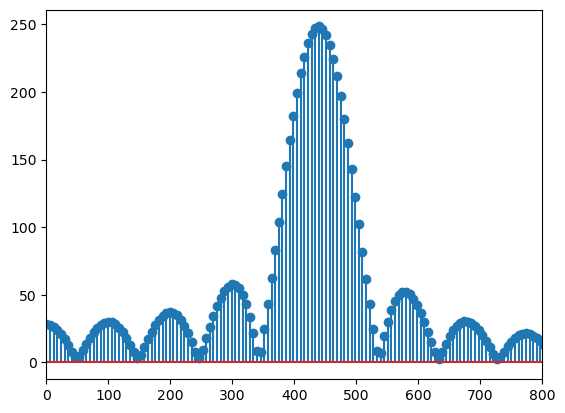

In [14]:
buffer_s = 512

fft_s = 8192

x_fft = fft_buf_zpad(melody, buffer_s, 10, fft_s)

# f_v = np.arange(0, sr, sr/(fft_s))

# plt.stem(f_v, x_fft)
# plt.xlim([0, 800])

### Applying Envelopes - Fade In

In [15]:
ramp = np.linspace(0, 1, 8192)
                   
frame = melody[0:8192]

fade_in = frame * ramp

Audio(fade_in, rate = sr)

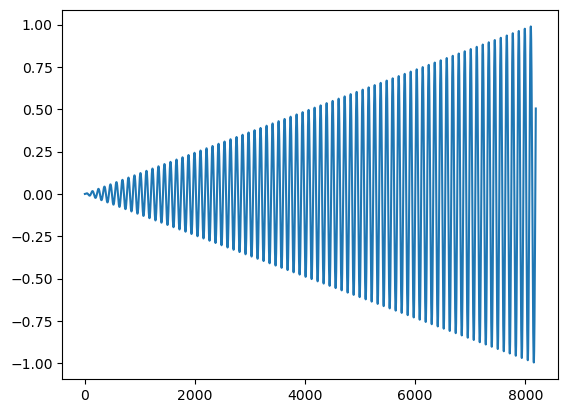

In [16]:
# plt.plot(frame)

plt.plot(fade_in)

### Manual Trapezoidal window

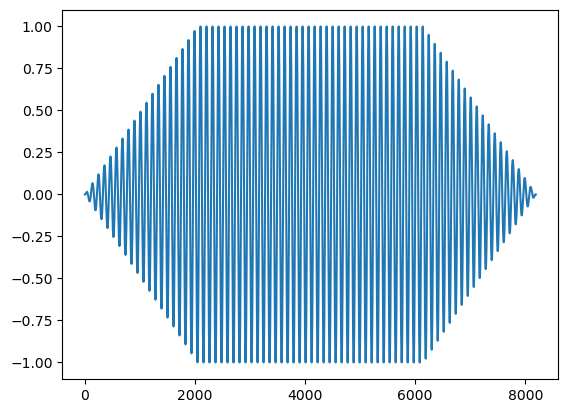

In [17]:
ramp_up = np.linspace(0, 1, int((1/4) * 8192))
sustain = np.ones(int((1/2) * 8192))
ramp_down = np.linspace(1, 0, int((1/4) * 8192))

win = np.concatenate([ramp_up, sustain, ramp_down])

# plt.plot(win)

frame = melody[0:8192]

frame_windowed = frame * win

Audio(frame_windowed, rate = sr)

plt.plot(frame_windowed)

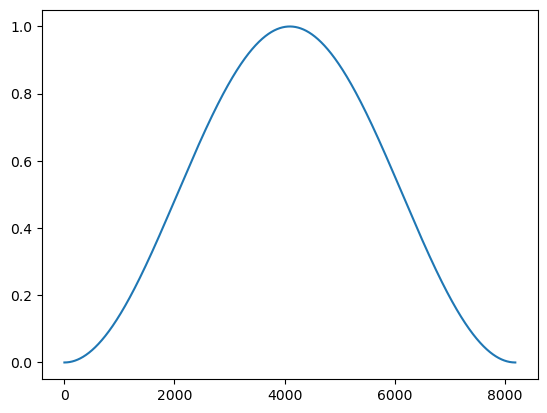

In [18]:
win_han = np.hanning(8192)

plt.plot(win_han)

### Non-overlapping STFT With Hanning window
Create a function that breaks an audio signal into chunks of audio and displays the fourier transform of ONE given buffer (Freq vs Amplitude) while applying the following window:

- ‘hanning’

Inputs:

- x [mono audio vector]
- frame_size [frame/buffer size]
- frame_num [frame/buffer to display]

In [19]:
def fft_buf_hann(x, frame_sz, disp_num, fft_len):
    num_frames = int(np.ceil(len(x) / frame_sz))
    mat = np.zeros([num_frames, frame_sz])
    
    for i in range(0, num_frames):
        start = i * frame_sz
        end = start + frame_sz
        # end = (i + 1) * frame_sz
        curr_frame  = x[start:end]
        #first number is inclusive
        #second is exclusive
        window = np.hanning(len(curr_frame))
        
        curr_frame = curr_frame * window
        
        mat[i, 0:len(curr_frame)] += curr_frame
    
    mat_fft = np.fft.rfft(mat[disp_num], fft_len)
    
    mag_fft = abs(mat_fft)
    
    # f_v = np.fft.rfftfreq(fft_len, 1/48000)
    f_v = np.arange(0, sr, sr/fft_len)
    
    plt.stem(f_v[0:len(mag_fft)], mag_fft)
    
    return mag_fft

(0.0, 800.0)

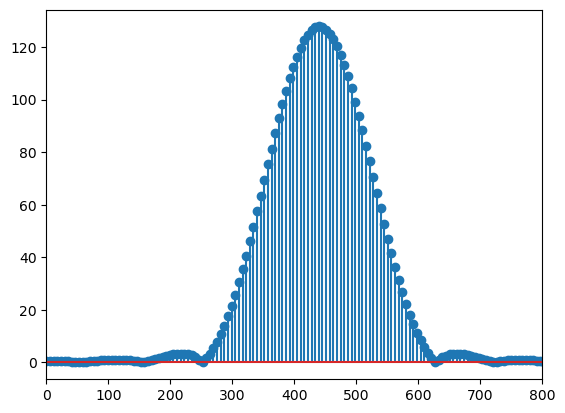

In [25]:
buffer_s = 512

fft_s = 8192

x_fft = fft_buf_hann(melody, buffer_s, 10, fft_s)
plt.xlim([0, 800])

(0.0, 800.0)

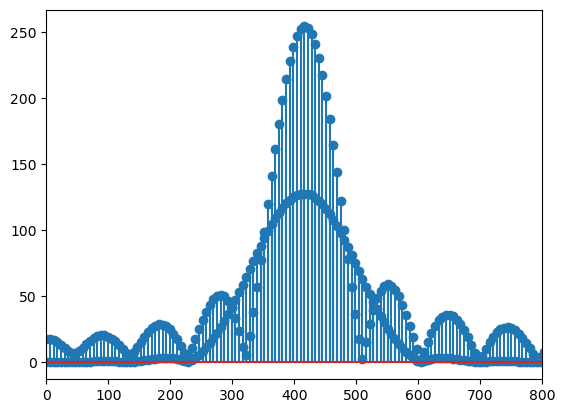

In [34]:
# plotting hanning vs rect

buffer_s = 512

fft_size = 8192

x_fft_hann = fft_buf_hann(melody,buffer_s,200, fft_size)

x_fft_rect = fft_buf_zpad(melody,buffer_s,200, fft_size)

f_v = np.arange(0,sr,sr/(fft_size))

plt.cla()
plt.stem(f_v[0:len(x_fft_hann)], x_fft_hann)
plt.stem(f_v[0:len(x_fft_hann)],x_fft_rect)
plt.xlim([0,800])

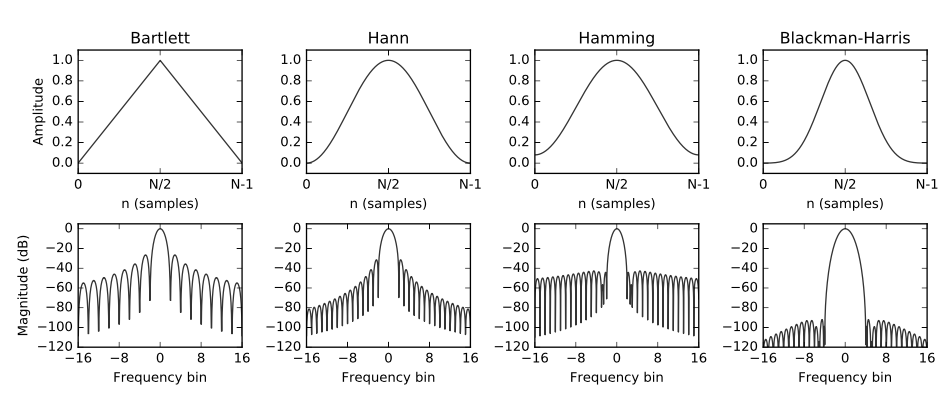

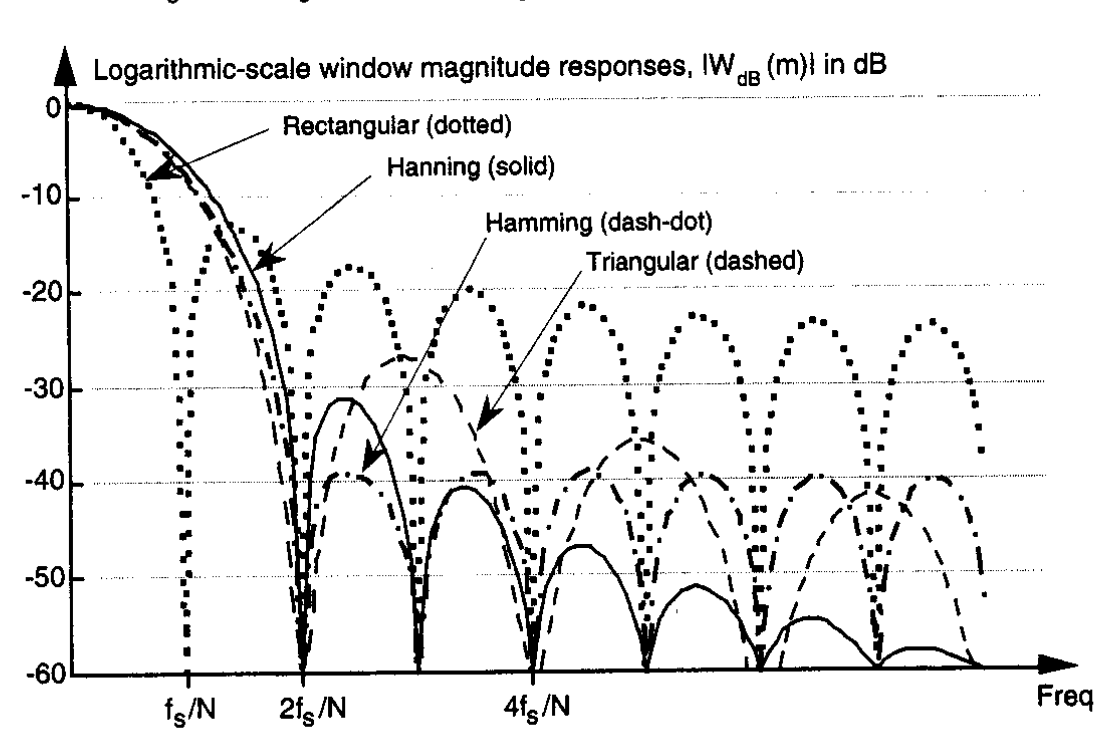

# STFT with configurable window

Create a function that breaks an audio signal into chunks of audio and displays the fourier transform of ONE given buffer (Freq vs Amplitude) while applying one of the following windows:

- ‘rectangular’
- ‘hamming’
- ‘hanning’
- ‘blackman’

Inputs:

- x [mono audio vector]
- buff_sz [frame/buffer size]
- frame [frame/buffer to display]
- win [type of window]